In [2]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [41]:
# 데이터 파싱
data = pd.read_csv('./Data/EmbeddingTrainData4.csv')
data = data.to_numpy()
data = np.delete(data, 0, axis=0)
data = np.delete(data, 0, axis=1)

np.random.shuffle(data)

train_data = data[:data.size * 0.8]
test_data = data[data.size * 0.8:]

train_x = []
train_y = []
test_x = []
test_y = []

for line in train_data:
  train_x.append(line[:27])
  train_y.append(line[28])

for line in test_data:
  test_x.append(line[:27])
  test_y.append(line[28])



outer_temp_train = []
for line in train_x:
  temp = []
  for word in line:
    word = word.replace('[', '')
    word = word.replace(']', '')
    temp.append(list(map(float, word.split(','))))

  outer_temp_train.append(temp)

train_x = outer_temp_train

outer_temp_test = []
for line in test_x:
  temp = []
  for word in line:
    word = word.replace('[', '')
    word = word.replace(']', '')
    temp.append(list(map(float, word.split(','))))

  outer_temp_test.append(temp)

test_x = outer_temp_test

for idx in range(len(train_y)):
  train_y[idx] = train_y[idx] - 3

for idx in range(len(test_y)):
  test_y[idx] = test_y[idx] - 3

train_y_origin = train_y
test_y_origin = test_y
train_y = to_categorical(train_y)
test_y = to_categorical(test_y)

In [43]:
print(data.shape)

(22588, 29)


In [30]:
#모델
# Dropout -> 과적합 방지를 위한 버리기
model = Sequential()
model.add(LSTM(512, activation='relu', input_shape=(27, 100), return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(256, activation='relu', return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(8, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('./best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

adam = optimizers.Adagrad(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['acc'])
history = model.fit(train_x, train_y.tolist(), epochs=5, batch_size=1, callbacks=[es, mc], validation_data=(test_x, test_y.tolist()))

Epoch 1/5
18070/18071 [============================>.] - ETA: 0s - loss: 1.4205 - acc: 0.2861
Epoch 1: val_acc improved from -inf to 0.27391, saving model to ./best_model.h5
18071/18071 [==============================] - 781s 43ms/step - loss: 1.4205 - acc: 0.2861 - val_loss: 1.4381 - val_acc: 0.2739
Epoch 2/5
18070/18071 [============================>.] - ETA: 0s - loss: 1.3926 - acc: 0.2802
Epoch 2: val_acc improved from 0.27391 to 0.27790, saving model to ./best_model.h5
18071/18071 [==============================] - 781s 43ms/step - loss: 1.3926 - acc: 0.2802 - val_loss: 1.3880 - val_acc: 0.2779
Epoch 3/5
18071/18071 [==============================] - ETA: 0s - loss: 1.3859 - acc: 0.2861
Epoch 3: val_acc improved from 0.27790 to 0.27989, saving model to ./best_model.h5
18071/18071 [==============================] - 779s 43ms/step - loss: 1.3859 - acc: 0.2861 - val_loss: 1.3854 - val_acc: 0.2799
Epoch 4/5
18070/18071 [============================>.] - ETA: 0s - loss: 1.3826 - acc: 0

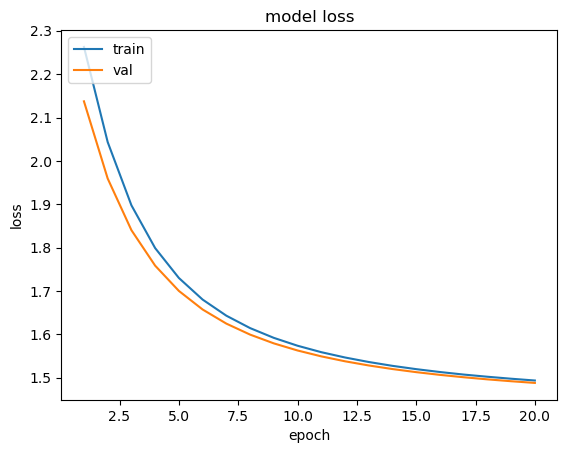

In [12]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [31]:
loaded_model = load_model('best_model.h5')
loaded_model.summary()
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(test_x, test_y.tolist())[1]))

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_48 (LSTM)              (None, 27, 512)           1255424   
                                                                 
 dropout_36 (Dropout)        (None, 27, 512)           0         
                                                                 
 lstm_49 (LSTM)              (None, 27, 256)           787456    
                                                                 
 dropout_37 (Dropout)        (None, 27, 256)           0         
                                                                 
 lstm_50 (LSTM)              (None, 128)               197120    
                                                                 
 dropout_38 (Dropout)        (None, 128)               0         
                                                                 
 dense_38 (Dense)            (None, 8)               

In [14]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(test_x, test_y.tolist())[1]))
#model.save('./softmax.h5')

142/142 [==============================] - 6s 41ms/step - loss: 1.4881 - acc: 0.2870

 테스트 정확도: 0.2870


In [25]:
print(test_y)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


565/565 [==============================] - 22s 39ms/step


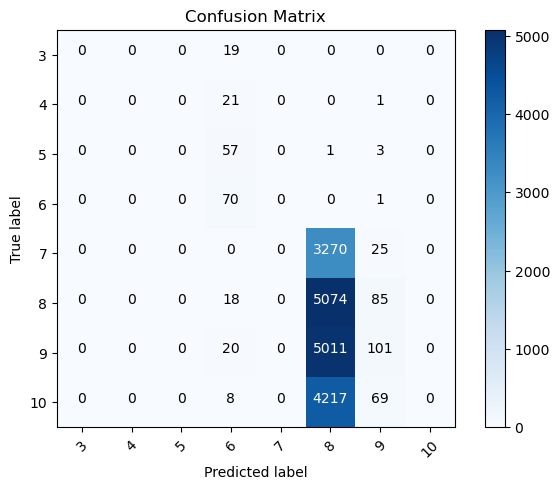

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 예측값 계산
y_pred = model.predict(train_x)
# 가장 높은 확률을 가진 클래스로 예측값 변환
y_pred_classes = np.argmax(y_pred, axis=1)
# 실제 클래스 변환
y_true = np.argmax(train_y, axis=1)

# 클래스 레이블
class_labels = ['3', '4', '5', '6', '7', '8', '9', '10']  # 클래스 레이블을 적절히 수정해야 합니다.

# 혼동 행렬 계산
confusion_mat = confusion_matrix(y_true, y_pred_classes)

# 혼동 행렬 그리기
plt.imshow(confusion_mat, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

num_classes = len(class_labels)
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)

# 텍스트로 혼동 행렬 값 표시
thresh = confusion_mat.max() / 2.
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, confusion_mat[i, j],
                 horizontalalignment="center",
                 color="white" if confusion_mat[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [42]:


unique_elements, counts = np.unique(train_y_origin, return_counts=True)

for element, count in zip(unique_elements, counts):
    print(f"{element}: {count}")

0: 16
1: 19
2: 60
3: 77
4: 3336
5: 5221
6: 5055
7: 4287
